# Final Compiled Version

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB 
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')

In [3]:
random.seed(2024)
np.random.seed(2024)
torch.manual_seed(2024)

## Helper functions

In [4]:
def scaler(col):
    return (col - np.min(col)) / (np.max(col) - np.min(col))


def vec_to_list(event_list):
    event_list = event_list.replace('[', '').replace(']', '').split()
    event_list = [int(float(x)) for x in event_list]
    return event_list


class Embedding(nn.Module):
    def __init__(self, embedding_dim, n_events=5):
        super().__init__()
        self.fc1 = nn.Linear(n_events, embedding_dim, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    

def preprocessing_steps(data):
    df = data.copy()
    df = df.drop(columns=['first_20_events', 'time_since_last_event', 'Unnamed: 1', 'downpayment_cleared', 'first_purchase',
                          'max_milestone', 'downpayment_received', 'account_activitation', 'customer_id'])
    
    df = df.dropna(axis=0)
    df_0, df_1 = df[df.order_ships == 0], df[df.order_ships == 1]
    df_0 = df_0.sample(n=len(df_1), random_state=2024)
    # df_1 = df_1.sample(n=(len(df_0)), replace=True)
    df_balanced = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

    # shuffle
    df_balanced = df_balanced.sample(frac=1)

    df_X = df_balanced.drop(columns='order_ships')
    target = df_balanced.order_ships
    ori_df = df.drop(columns='order_ships')
    ori_target = df.order_ships

    boolean_col = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']

    for col in boolean_col:
        df_X[col] = [1 if val == True else 0 for val in df_X[col]]
        ori_df[col] = [1 if val == True else 0 for val in ori_df[col]]


    return ori_df, ori_target, df_X, target


def preprocessing_steps_embedding(data):
    df = data.copy()
    df = df.drop(columns=['Unnamed: 1', 'downpayment_cleared', 'first_purchase',
                          'max_milestone', 'downpayment_received', 'account_activitation', 'customer_id'])
    df = df.astype({col: 'float' for col in df.columns[:-2]})
    
    df = df.dropna(axis=0)


    events = df['first_20_events'].apply(vec_to_list)
    events = torch.tensor(events.to_list()).float()
    events_emb = Embedding(5, 20)
    events = events_emb(events)
    event_pd = pd.DataFrame(events.detach().numpy(), columns=[f'event_id_{i}' for i in range(5)])

    time = df['time_since_last_event'].apply(vec_to_list)
    time = torch.tensor(time.to_list()).float()
    time_emb = Embedding(5, 20)
    time = time_emb(time)
    time_pd = pd.DataFrame(time.detach().numpy(), columns=[f'time_{i}' for i in range(5)])
    df = pd.concat([df, event_pd, time_pd], axis=1)
    df = df.drop(columns=['first_20_events', 'time_since_last_event'])


    df_0, df_1 = df[df.order_ships == 0], df[df.order_ships == 1]
    df_0 = df_0.sample(n=len(df_1), random_state=2024)
    # df_1 = df_1.sample(n=(len(df_0)), replace=True)
    df_balanced = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

    # shuffle
    df_balanced = df_balanced.sample(frac=1)

    df_X = df_balanced.drop(columns='order_ships')
    target = df_balanced.order_ships
    ori_df = df.drop(columns='order_ships')
    ori_target = df.order_ships

    boolean_col = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']

    for col in boolean_col:
        df_X[col] = [1 if val == True else 0 for val in df_X[col]]
        ori_df[col] = [1 if val == True else 0 for val in ori_df[col]]


    return ori_df, ori_target, df_X, target

## Reading in Data

In [6]:
new_dfx = pd.read_csv('data_with_embeddings.csv')
new_dfx = new_dfx.dropna(axis=0)
num_cols = ['num_journeys', 'max_journey', 'number_accounts', 'average_length_seq', 
            'time_in_discover', 'time_in_apply', 'time_max', 'time_mean', 'time_std', 
            'total_time_spent', 'event_embd_0', 'event_embd_1', 'event_embd_2', 
            'event_embd_3','event_embd_4', 'time_embd_0', 'time_embd_1', 'time_embd_2',
            'time_embd_3', 'time_embd_4']

categorical_cols = ['most_repeated_event', 'initial_device']
boolean_cols = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']
target = 'order_ships'
X_train, X_test, y_train, y_test = train_test_split(new_dfx.drop(columns='order_ships'), 
                                                    new_dfx.order_ships, 
                                                    test_size=0.2,
                                                    stratify=new_dfx.order_ships,
                                                    random_state=2024)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


numerical = X_train.loc[:,num_cols]

scaler = StandardScaler()
scaler.fit(numerical)
numerical_tran = scaler.transform(numerical)
numerical_test = scaler.transform(X_test[num_cols])
numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1) 

In [7]:
y = new_dfx['order_ships'].reset_index(drop=True)
X = new_dfx.drop(columns=['order_ships']).reset_index(drop=True)

## Preliminary Models

### Preliminary models

In [17]:
log_clf = LogisticRegression(random_state=2024)
log_clf.fit(X_train, y_train)
log_prediction = log_clf.predict(X_test)
print(accuracy_score(y_test, log_prediction))
print(f1_score(y_test, log_prediction))

0.8284489049450896
0.3814988848227627


In [20]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_prediction = nb.predict(X_test)
print(accuracy_score(y_test, nb_prediction))
print(f1_score(y_test, nb_prediction))

0.7117841902479602
0.5222153080273801


In [15]:
dt = DecisionTreeClassifier(max_depth=5, random_state=2024)
dt.fit(X_train, y_train)
dt_prediction = dt.predict(X_test)
print(accuracy_score(y_test, dt_prediction))
print(f1_score(y_test, dt_prediction))

0.8317192046775196
0.49906583828722123


In [ ]:
ada = AdaBoostClassifier(n_estimators=200, learning_rate=.1, random_state=2024)
ada.fit(X_train, y_train)
ada_prediction = ada.predict(X_test)
print(accuracy_score(y_test, ada_prediction))
print(f1_score(y_test, ada_prediction))

In [ ]:
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=2024)
gb.fit(X_train, y_train)
gb_prediction = gb.predict(X_test)
print(accuracy_score(y_test, gb_prediction))
print(f1_score(y_test, gb_prediction))

In [ ]:
lgbm = LGBMClassifier(n_estimators=200,
                      max_depth=10, 
                      learning_rate=0.1,
                      objective='binary',
                      verbose=-1,
                      random_state=2024)

lgbm.fit(X_train, y_train)
lgbm_prediction = lgbm.predict(X_test)
print(accuracy_score(y_test, lgbm_prediction))
print(f1_score(y_test, lgbm_prediction))

0.884383342792878
0.6653919694072659


In [9]:
xgb_clf = XGBClassifier(n_estimators=200,
                        max_depth=10,
                        learning_rate=0.1,
                        tree_method='hist',
                        objective='binary:logistic',
                        random_state=2024)

xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
print(accuracy_score(y_test, xgb_pred))
print(f1_score(y_test, xgb_pred))

0.8916296543212101
0.6991621858196825


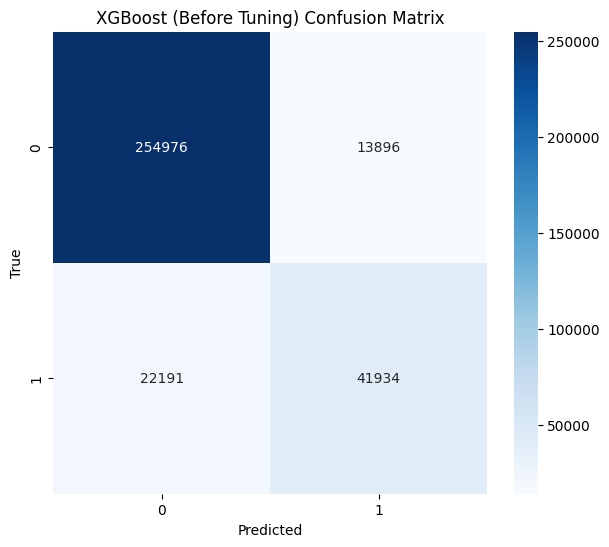

In [11]:
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost (Before Tuning) Confusion Matrix')
plt.show()

## XGBoost Hyperparameter Tuning

In [ ]:
import optuna

def objective(trial):
    params = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'random_state': 2024,
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0)
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    prediction = model.predict(X_test)
    f1 = f1_score(y_test, prediction)

    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [24]:
study.best_params

{'n_estimators': 354,
 'max_depth': 10,
 'learning_rate': 0.09777273210428525,
 'subsample': 0.7355818769405801,
 'gamma': 3.513270943451698,
 'scale_pos_weight': 1.7901629274544835,
 'reg_alpha': 0.8063538782719757,
 'reg_lambda': 3.8289679315225817}

In [12]:
best_params = {'n_estimators': 354,
               'max_depth': 10,
               'learning_rate': 0.09777273210428525,
               'subsample': 0.7355818769405801,
               'gamma': 3.513270943451698,
               'scale_pos_weight': 1.7901629274544835,
               'reg_alpha': 0.8063538782719757,
               'reg_lambda': 3.8289679315225817}

In [13]:
xgb_clf = XGBClassifier(**best_params,
                        tree_method='hist',
                        objective='binary:logistic',
                        random_state=2024)

xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
print(accuracy_score(y_test, xgb_pred))
print(f1_score(y_test, xgb_pred))

0.883275224701724
0.7293339368406392


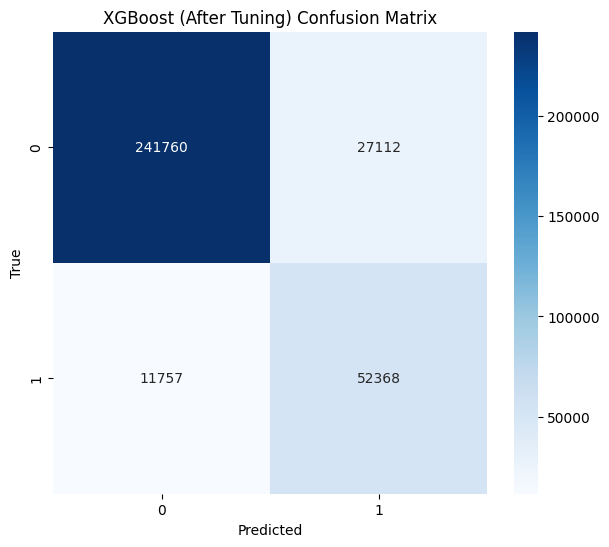

In [14]:
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost (After Tuning) Confusion Matrix')
plt.show()

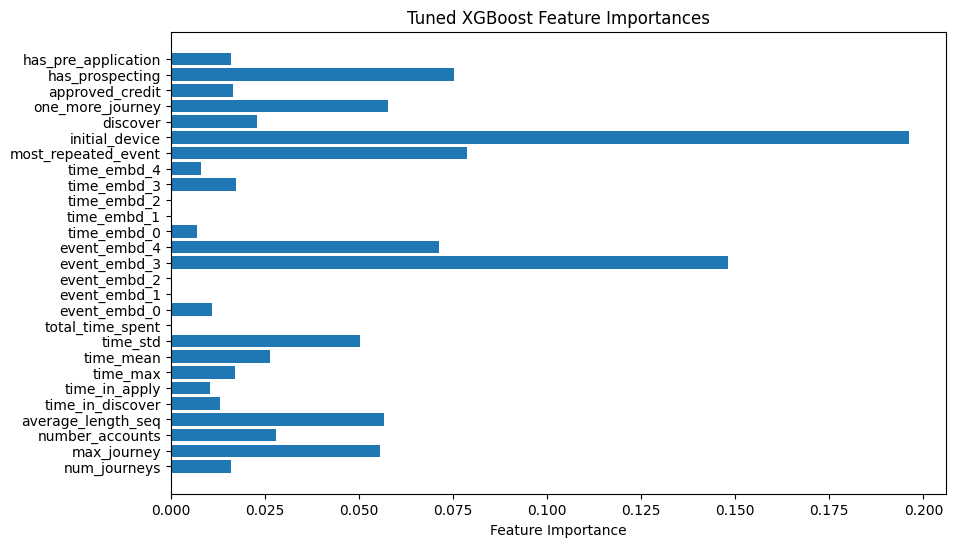

In [21]:
plt.figure(figsize=(10, 6))
plt.barh(xgb_clf.feature_names_in_, xgb_clf.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('Tuned XGBoost Feature Importances')
plt.show()